## HMM EXERCISE 1 


#### PROBLEM DESCRIPTION
A silence-speech detector classifies incoming data as either speech or silence, depending on the short-time energy E of the input signal. 
The measured energy is labelled (quantized) as follows : 
> A := (E ≤30dB)   
> B := (30 dB < E ≤40 dB)    
> C := (E > 40 dB)    

Use an HMM with 2 states to model this process. 
- In the silence state, the probability of producing A, B or C is 0.7, 0.1 and 0.2 respectively. 
- In the speech state, these probabilities are 0.1, 0.5 and 0.4. 
- The probability for a transition from the silence state to the speech state or vice versa is 0.3. 

#### TASKS
1. Make a drawing of the HMM, indicate all probabilities. 
2. Make a Trellis diagram and compute both the Forward Pass score and the Viterbi score for observation \[15 35 60 25\] assuming it corresponds to an utterance embedded in silence. 
3. Align the observations against the states for the Viterbi case

#### INSTRUCTIONS
The best way to truly understand the lowest level computations in HMMs is to make these exercises **BY HAND**.   
This notebook will provide you with computer solutions with which you can compare your pencial and paper solution.  The notebook uses the pyspch.stats.libhmm package for the computations.  You still need to interpret the results.

### pypch.stats.libhmm
The *libhmm* package is specifically designed to work with Hidden Markov Models.  
It was developed for demonstration and didactic purposes.    
*libhmm* takes care of everything EXCEPT the obsservation probabilities.
Observation probabilities are generated by a Density object, eg. as existing in the *pyspch.stats.probdist* library, or by an object supporting the same interface.
Also observation probabilities can be fed directly as inputs.

Two classes are provided:
- hmm: hmm model class
    + attributes
        + n_states: number of states
        + initmat:  initial probabilities
        + transmat: transition probabilities (A-matrix)
        + obs_model: observation model
        + states: state names
        + prob_style: 'lin' or 'log'   work with probs or log-probs
    + methods
        + observation_prob(): compute observation probs for a given input
        + align(): find Viterbi alignment
        + fit(): Viterbi training
        + print_model()
        
- Trellis: trellis class
    + attributes
        + hmm: the hmm to use
        + end_states: admissible end_states
        + obs_probs, probs, backptrs, alignment, ... internally computed values
    + methods
        + viterbi_pass(), forward_pass():  trellis computations with Viterbi or Forward algorithm
        + backtrace(): 
        + print_trellis()
        + plot_trellis()

In [1]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
# do all the imports
%matplotlib inline

import sys, os
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy

import pyspch.stats.probdist as Densities
from pyspch.stats import libhmm

In [3]:
# graphical and print preferences
ldesign = 50
cmap = sns.light_palette("caramel",ldesign,input="xkcd")
cmap20 = cmap[0:20] 
pd.reset_option('display.float_format')
pd.set_option('display.precision',3)
mpl.rcParams['figure.figsize'] = [12.0, 6.0]
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlepad'] = 15
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.linewidth'] = 2
mpl.rc('lines', linewidth=3, color='k')

#### SOLUTION

#### 1. Design of a 2-state silence-speech model

1. First we create the "observation model" for the two states
- we define a set of discrete probabily functions with the matching parameters

2. The we create an HMM
- the transition matrix
- state names
- the previously defined observation models and linking them to the correct states
- initial and final probabilities are set as follows:
    + we assume that all sequences will start in the SIL state (default assumption in the software)
    + we also assume that all sequences will end in SIL; the admmissible end states are specified in end_states[]

In [4]:
Bmat = np.array([ [0.7, 0.1, 0.2], [0.1, 0.5, 0.4] ])
dd1 = Densities.Discrete(feature_probs=[Bmat],labels=[np.array(['A','B','C'])],classes=np.array(['SIL','SP']) )

Amat = np.array([[0.7, 0.3],[0.3,0.7]])
hmm1 = libhmm.HMM(n_states=2,states=['SIL','SP'],
                   obs_model=dd1, transmat=Amat )   
# force an alignment to end in SIL state
hmm1.end_states=[0]
hmm1.print_model()



HMM STATE MODEL



,SIL,SP
Pinit(.),1.0,0.0


,SIL,SP
P(SIL|.),0.7,0.3
P(SP|.),0.3,0.7



OBSERVATION MODEL

++ Feature (0) ++
 


,SIL,SP
P(0|.),0.7,0.1
P(1|.),0.1,0.5
P(2|.),0.2,0.4


In [5]:
# define quantizer according to the specs and quantize the continuous features
def vq1(x):
    if x <= 30: return('A')
    elif x <= 40.: return('B')
    else: return('C')
X1_c = [ 15., 35., 60., 25.]
X1l = [ vq1(x) for x in X1_c ]
#
print("Continuous Feature stream: ",X1_c)
print("Quantized  Feature stream: ",X1l)

Continuous Feature stream:  [15.0, 35.0, 60.0, 25.0]
Quantized  Feature stream:  ['A', 'B', 'C', 'A']


In [6]:
# we convert our input feature labels to indices first
X1 = dd1.lbl2indx(np.asarray(X1l).reshape(-1,1))
#= np.array([  0, 1, 2, 0]).reshape(-1,1)
trellis1 = libhmm.Trellis(hmm1)
trellis1.viterbi_pass(X1)
trellis1.print_trellis(X=X1)


Observations



,0,1,2,3
X,0,1,2,0



Observation Probabilities



,0,1,2,3
SIL,0.7,0.1,0.2,0.7
SP,0.1,0.5,0.4,0.1



Trellis Probabilities (Viterbi)



,0,1,2,3
SIL,0.7,0.049,0.007,0.006
SP,0.0,0.105,0.029,0.002



Alignment



,0,1,2,3
VIT-ALIGN,SIL,SP,SP,SIL



Sequence Probability: 6.17e-03



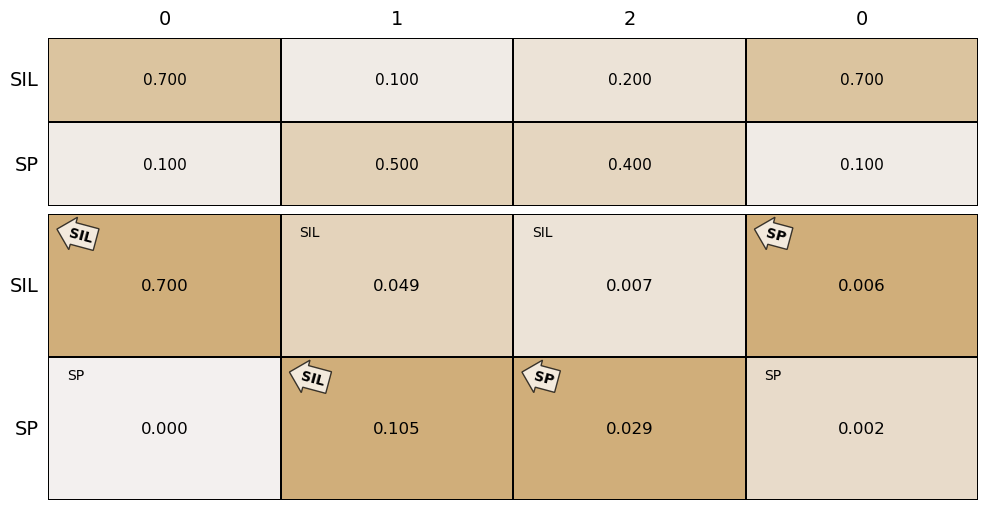

In [7]:
# The plot_trellis() module just gives another visualization option for the information in the trellis
#
trellis1.plot_trellis(xticks=X1.flatten(),plot_obs_probs=True,plot_backptrs=True,plot_alignment=True,
                plot_norm=True,vmin=0.,vmax=2,cmap=cmap)

#### 2. Training of a Discrete Density Model

In [8]:
# Define a small sample training data set
#
# use X1 and its alignment
S1 = trellis1.backtrace()
# use other data
X2l = ['B','A','B','B','C','A']
S2l = ['SIL','SIL','SP','SP','SP','SIL']
X3l = ['A','B','C','B','C','A','C','A']
S3l = ['SIL','SP','SP','SP','SP','SIL','SIL','SIL']
# convert everything to indices to work with
X2 = dd1.lbl2indx(np.asarray(X2l).reshape(-1,1))
X3 = dd1.lbl2indx(np.asarray(X3l).reshape(-1,1))
S2 = [np.where(hmm1.states == s)[0][0] for s in S2l]
S3= [np.where(hmm1.states == s)[0][0] for s in S3l]
#
X2.T,S2, X3.T, S3

(array([[1, 0, 1, 1, 2, 0]]),
 [0, 0, 1, 1, 1, 0],
 array([[0, 1, 2, 1, 2, 0, 2, 0]]),
 [0, 1, 1, 1, 1, 0, 0, 0])

In [9]:
# create a new model with same topology and style of observation model
hmm_retrained = copy.copy(hmm1)
# index=True is required in next line to work with indices (code is not always consistent :))
hmm_retrained.fit([X1,X2,X3],[S1,S2,S3],index=True)  
hmm_retrained.print_model()


HMM STATE MODEL



,SIL,SP
Pinit(.),1.0,0.0


,SIL,SP
P(SIL|.),0.5,0.333
P(SP|.),0.5,0.667



OBSERVATION MODEL

++ Feature (0) ++
 


,SIL,SP
P(0|.),0.7,0.1
P(1|.),0.1,0.5
P(2|.),0.2,0.4


### Additional Materials
#### Example Training Code
Below is some minimal code implementing the training for this very specific example (single feature discrete densities)
It is easier to read than the libhmm implementation that works vector inputs and various observation models

In [10]:
train_set = []
train_set.append({'X':X1,'S':S1})
train_set.append({'X':X2,'S':S2})
train_set.append({'X':X3,'S':S3})

def viterbi_train(trn,n_labels=1,n_states=1):
    n_train = len(trn)
    obs_counts = np.zeros((n_states,n_labels),dtype='float')
    init_counts = np.zeros(n_states,dtype='float')
    trans_counts = np.zeros((n_states,n_states),dtype='float')
    # counting
    for i in range(0,n_train):
        init_counts[trn[i]["S"][0]] += 1.
        for j in range(len(trn[i]["X"])):
            obs_counts[trn[i]["S"][j],trn[i]["X"][j]] += 1.
            if j>0:
                trans_counts[ trn[i]["S"][j-1],trn[i]["S"][j] ] += 1.
    state_counts = np.sum(obs_counts,axis=1)
    op = obs_counts / state_counts[:,np.newaxis]
    tp = trans_counts / np.sum(trans_counts,axis=1)[:,np.newaxis]
    ip = init_counts / np.sum(init_counts)
    return op,tp,ip

op, tp, ip = viterbi_train(train_set,n_labels=3,n_states=2)

# create a new observation model
dd_retrained = copy.copy(dd1) 
dd_retrained.feature_probs = [ op ]

# update all HMM parameters
hmm_retrained = copy.copy(hmm1)
hmm_retrained.transmat = tp
hmm_retrained.obs_model = dd_retrained
hmm_retrained.initmat = ip

# print the new model
hmm_retrained.print_model()


HMM STATE MODEL



,SIL,SP
Pinit(.),1.0,0.0


,SIL,SP
P(SIL|.),0.5,0.333
P(SP|.),0.5,0.667



OBSERVATION MODEL

++ Feature (0) ++
 


,SIL,SP
P(0|.),0.7,0.1
P(1|.),0.1,0.5
P(2|.),0.2,0.4


####  Matching a Continuous Density Model
The **discrete density** model has symbols as observations and simple discrete density observation probabilities.
In a **continous density** model has continuous feature vectors as observations requiring a density model to map from 
observation to probability of the observation.  

In the example above we could skep the quantization step on the input and use a continuoud probabilistic model instead.   
In the example we use a simpe single one dimensional Gaussian density.  We set parameters (means and variances) that are consistent with the discrete model described above.  These parameters were nor given, nor trained, just smart guessed.   
Except for the computation of the FRAME PROBABILITIES all other steps are identical to the discrete density model.

In [11]:
def gpdf(x,mu,sig):
    z = (x-mu)/sig
    ss = 1./(np.sqrt(2.*np.pi)*sig)
    return(ss * np.exp(-0.5*z*z))
def cdprobs(xlist):
    pdf1 = np.array([gpdf(x,20,10) for x in xlist]).reshape(-1,1)
    pdf2 = np.array([gpdf(x,50,20) for x in xlist]).reshape(-1,1)
    return( np.hstack([pdf1 , pdf2]) )

In [12]:
X2 =  [15., 35., 60.,25.]
X2probs = cdprobs(X2)
print(X2probs)

[[3.52065327e-02 4.31386594e-03]
 [1.29517596e-02 1.50568716e-02]
 [1.33830226e-05 1.76032663e-02]
 [3.52065327e-02 9.13245427e-03]]


In [13]:
# in this code we feed directly observation probabilities into the HMM
hmm2 =  libhmm.HMM(n_states=2,states=['SIL','SP'],transmat=Amat,obs_model=None ) 
hmm2.print_model()
trellis2 = libhmm.Trellis(hmm2)
trellis2.viterbi_pass(X2probs)
trellis2.print_trellis()


HMM STATE MODEL



,SIL,SP
Pinit(.),1.0,0.0


,SIL,SP
P(SIL|.),0.7,0.3
P(SP|.),0.3,0.7



OBSERVATION MODEL

Nothing to print


Observation Probabilities



,0,1,2,3
SIL,0.035,0.013,1.338e-05,0.035
SP,0.004,0.015,1.760e-02,0.009



Trellis Probabilities (Viterbi)



,0,1,2,3
SIL,0.035,3.192e-04,2.990e-09,2.070e-08
SP,0.000,1.590e-04,1.960e-06,1.253e-08



Alignment



,0,1,2,3
VIT-ALIGN,SIL,SP,SP,SIL



Sequence Probability: 2.07e-08

